In [1]:
import numpy as np
import pickle

import matplotlib.pyplot as plt
import matplotlib.lines as mlines

import colorcet as cc

from mpl_toolkits.axes_grid1 import make_axes_locatable

from mogtrain import *

from tqdm import tqdm_notebook as tqdm

import delfi.distribution as dd

from delfi.utils.viz import probs2contours

from parameters import ParameterSet
import pickle

%matplotlib inline

In [2]:
params = pickle.load(open('example_mog.pkl', 'rb'))

In [3]:
def print_pdf(pdf, name):
    po = np.get_printoptions()
    np.set_printoptions(precision=2)
    print("{}:".format(name))
    print("----------------")
    print("Mixture weights: {}".format(pdf.a))
    print("Means:")
    for x in pdf.xs:
        print("{}".format(x.m))
    print()
    print("Covariances:")
    for x in pdf.xs:
        print("{}".format(x.S))
    print()
    np.set_printoptions(**po)

In [5]:
mixture = DefensiveDistribution(params.prop, prior=params.prior, alpha=params.prior_mixin)

trainer = MoGTrainer(mixture, params.prior, params.uncorrected, n_components=params.n_comps, nsamples=10000, 
                     lr=0.01, es_thresh=0, es_rounds=500, init_to_qphi=True)

losses = trainer.train(nsteps=-1)

pred = trainer.get_mog()
params.target = params.uncorrected

loss=[ 1.38610899]: : 1339it [00:10, 123.63it/s]


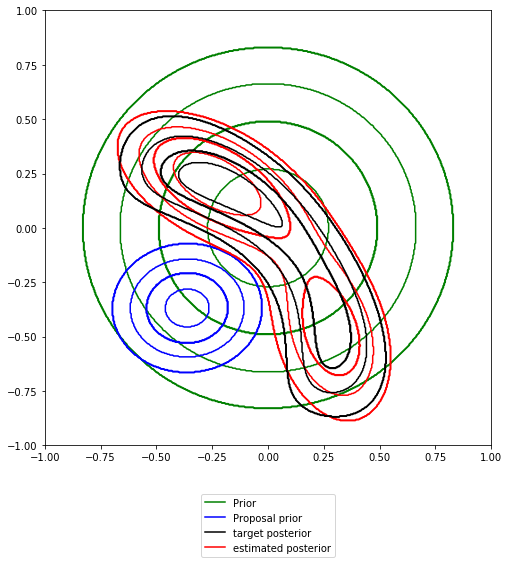

Estimated posterior:
----------------
Mixture weights: [ 0.54  0.46]
Means:
[-0.25  0.21]
[ 0.29 -0.5 ]

Covariances:
[[ 0.09 -0.03]
 [-0.03  0.05]]
[[ 0.04 -0.02]
 [-0.02  0.1 ]]



In [6]:
res = 500
xlims = (-params.x_width, params.x_width)
ylims = xlims

params.target = params.uncorrected

xaxis = np.linspace(*xlims, res)
yaxis = np.linspace(*ylims, res)
x, y = np.meshgrid(xaxis, yaxis)

xy = np.concatenate([x.reshape([-1, 1]), 
                     y.reshape([-1, 1])], 
                    axis=1)

levels = [0.7, 0.5, 0.3, 0.1]

prior_contour = probs2contours(params.prior.eval(xy, log=False), levels).reshape(res, res)
prop_contour = probs2contours(params.prop.eval(xy, log=False), levels).reshape(res, res)
pred_contour = probs2contours(pred.eval(xy, log=False), levels).reshape(res, res)

plt.figure(figsize=(8, 8))

plt.contour(x, y, prior_contour, colors=('g'))
plt.contour(x, y, prop_contour, colors=('b'))
plt.contour(x, y, pred_contour, colors=('r'))

if params.target is not None:
    target_contour = probs2contours(params.target.eval(xy, log=False), levels).reshape(res, res)
    plt.contour(x, y, target_contour, colors=('k'))

green_line = mlines.Line2D([], [], color='g', label='Prior')
blue_line = mlines.Line2D([], [], color='b', label='Proposal prior')
black_line = mlines.Line2D([], [], color='k', label='target posterior')
red_line = mlines.Line2D([], [], color='r', label='estimated posterior')
plt.legend(handles=[green_line, blue_line, black_line, red_line], 
           loc=9, bbox_to_anchor=(0.5, -0.1))

plt.show()

if isinstance(params.target, dd.MoG):
    print_pdf(params.target, "Target posterior")
    
print_pdf(pred, "Estimated posterior")

ValueError: Specified levels [0.0, 0.42499999999999999, 0.84999999999999998, 1.2749999999999999, 1.7]
 don't match available levels [ 0.2125  0.425   0.6375  0.85    1.0625  1.275 ]

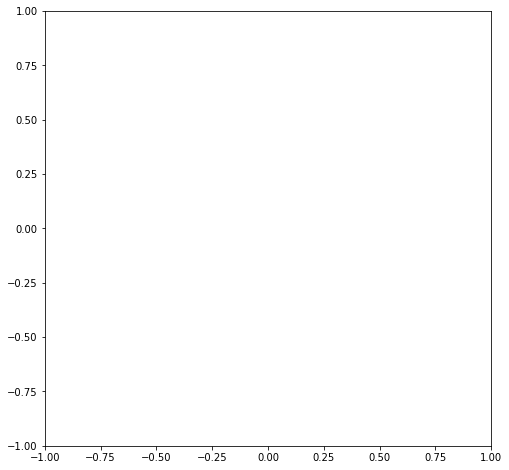

In [8]:
res = 500
xlims = (-params.x_width, params.x_width)
ylims = xlims

xaxis = np.linspace(*xlims, res)
yaxis = np.linspace(*ylims, res)
X, Y = np.meshgrid(xaxis, yaxis)
xy = np.concatenate([X.reshape([-1, 1]), Y.reshape([-1, 1])], axis=1)

pred_ylist = pred.eval(xy, log=False).reshape(res, res)
target_ylist = params.target.eval(xy, log=False).reshape(res, res)

decd = 1
vmax = np.ceil(np.max(target_ylist) * (10 ** decd)) / (10 ** decd)
cm_ticks = np.linspace(0, vmax, 9)

fig = plt.figure(figsize=(8, 8))
ax = plt.gca()

levels = cm_ticks

cont = plt.contour(X, Y, pred_ylist, levels=levels, colors=('w'))

plt.clabel(cont, levels[::2], inline=1, fontsize=10, fmt='%.{}f'.format(decd))

plt.xticks([])
plt.yticks([])

white_line = mlines.Line2D([], [], color='w', label='approximate proposal')

leg = plt.legend(handles=[white_line], loc='upper right', frameon=False)

divider = make_axes_locatable(ax)
axcbar = divider.append_axes("bottom", size="5%", pad=0.05)

imx = ax.imshow(target_ylist, cmap=cc.cm['linear_bgy_10_95_c74'], 
                extent=[xlims[0], xlims[1], ylims[0], ylims[1]], vmin=0, vmax=vmax,
                origin='lower')


cbar = plt.colorbar(imx, ticks=cm_ticks[::2], orientation='horizontal', cax=axcbar, format='%.{}f'.format(decd))
cbar.set_label("Target proposal density")

for text in leg.get_texts():
    text.set_color('w')

plt.show()

In [ ]:
# Contour lines according to posterior masses

In [ ]:
plt.savefig("prop_appr.svg", transpare)